In [1]:
# Importing Packages
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML  # To embed html into python output


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Set all the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Downloads/Potato_img",
    seed=123,   # fixed value for shuffling and transformation.
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for x in dataset.take(1):
    print(x)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[142., 116., 117.],
         [137., 111., 112.],
         [107.,  81.,  82.],
         ...,
         [173., 155., 151.],
         [182., 164., 160.],
         [196., 178., 174.]],

        [[138., 112., 113.],
         [137., 111., 112.],
         [132., 106., 107.],
         ...,
         [175., 157., 153.],
         [177., 159., 155.],
         [185., 167., 163.]],

        [[117.,  91.,  92.],
         [112.,  86.,  87.],
         [144., 118., 119.],
         ...,
         [176., 158., 154.],
         [176., 158., 154.],
         [181., 163., 159.]],

        ...,

        [[107.,  81.,  80.],
         [146., 120., 119.],
         [126., 100.,  99.],
         ...,
         [163., 143., 142.],
         [167., 147., 146.],
         [171., 151., 150.]],

        [[115.,  89.,  88.],
         [124.,  98.,  97.],
         [160., 134., 133.],
         ...,
         [161., 141., 140.],
         [165., 145., 144.],
       

In [7]:
for images_ineachbatch, labels_ineachbatch in dataset.take(1):     # take(1) is uesd to take 1st element from dataset.
    print(images_ineachbatch.shape)   #here each batch contains 32 images. each image contain 256*256*3 pixel values
    print(labels_ineachbatch.numpy())   # labels of 32 images in 1 batch.

(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


In [8]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

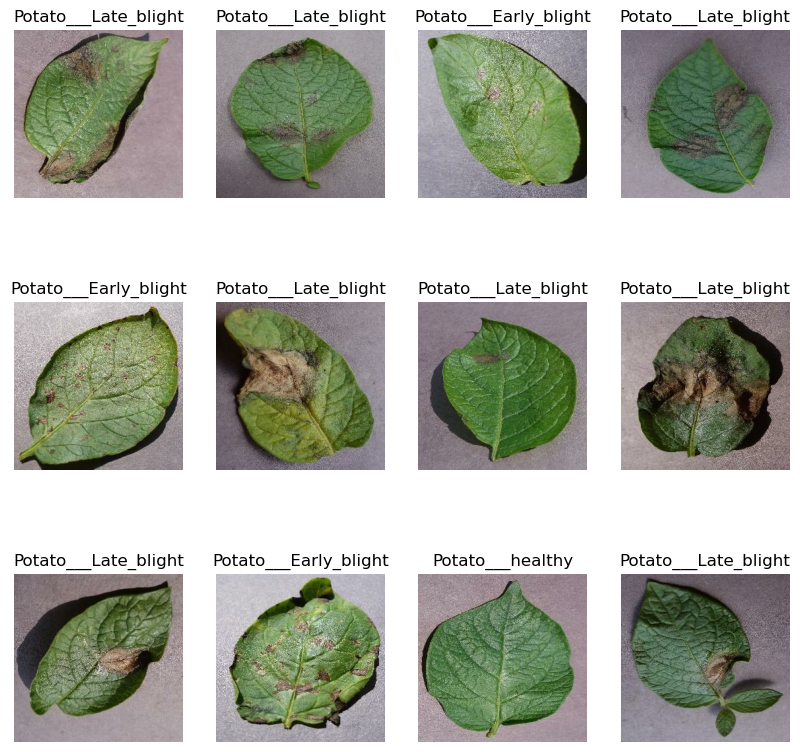

In [9]:
# Visualisation of Images from Dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i + 1)  # Here in subplot grid (3-no of rows, 4 - no of columns, i= which index to work on)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # u r converting float value into round integers to draw images easily
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
# Creating a function to split Dataset for train,test:

def get_dataset_partiion_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    assert(train_split + val_split + test_split )== 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, test_ds, val_ds = get_dataset_partiion_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(test_ds)

6

In [14]:
len(val_ds)

8

In [15]:
# Cache, Shuffle, Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# Resizing and Normalisation
# Before we feed our images to network, we should be resizing it to the desired size. 
# To improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
# Data Augmentaion:
# Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
# Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)  # we can build the model without using this code.

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [20]:
# Model compiling
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
# Training the Model

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=3, # in high gpus, u can use 50 epochs
)

Epoch 1/3
54/54 [==============================] - 52s 955ms/step - loss: 0.3314 - accuracy: 0.8698 - val_loss: 0.3449 - val_accuracy: 0.8750
Epoch 2/3
54/54 [==============================] - 51s 953ms/step - loss: 0.3095 - accuracy: 0.8750 - val_loss: 0.1630 - val_accuracy: 0.9219
Epoch 3/3
54/54 [==============================] - 51s 952ms/step - loss: 0.1731 - accuracy: 0.9282 - val_loss: 0.0975 - val_accuracy: 0.9609


In [23]:
# Predicting using Test dataset
scores = model.evaluate(test_ds)

6/6 [==============================] - 5s 188ms/step - loss: 0.1050 - accuracy: 0.9688


In [24]:
scores     # It has loss and accuracy value

[0.104983389377594, 0.96875]

In [ ]:
# You can see above that we get 96% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [25]:
history.history

{'loss': [0.33136048913002014, 0.3094964623451233, 0.17310944199562073],
 'accuracy': [0.8697916865348816, 0.875, 0.9282407164573669],
 'val_loss': [0.3449352979660034, 0.16302074491977692, 0.09751620143651962],
 'val_accuracy': [0.875, 0.921875, 0.9609375]}

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

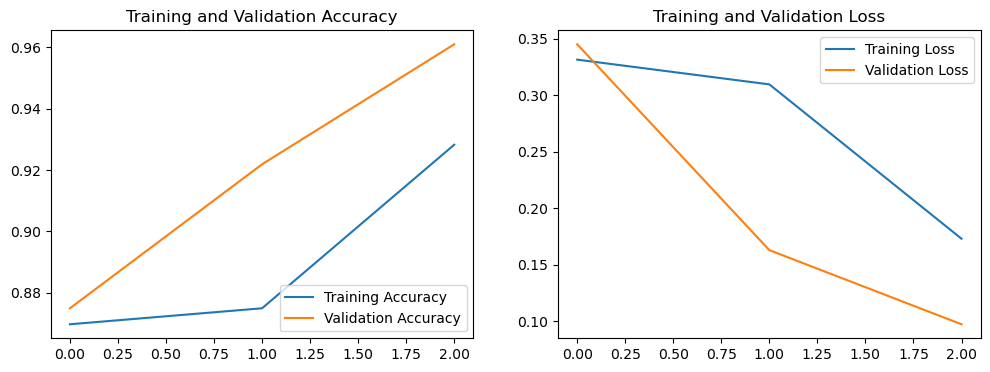

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(3), acc, label='Training Accuracy')
plt.plot(range(3), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(3), loss, label='Training Loss')
plt.plot(range(3), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 198ms/step
predicted label: Potato___Late_blight


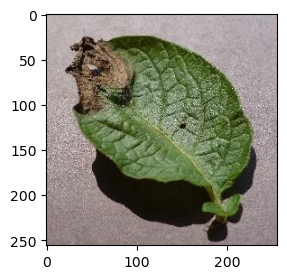

In [38]:
# Prediction on sample image

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.figure(figsize=(3, 3))
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
# Creating a function for Prediction inference:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) 
    img_array = tf.expand_dims(img_array, 0) # It increases the dimension of an array.
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


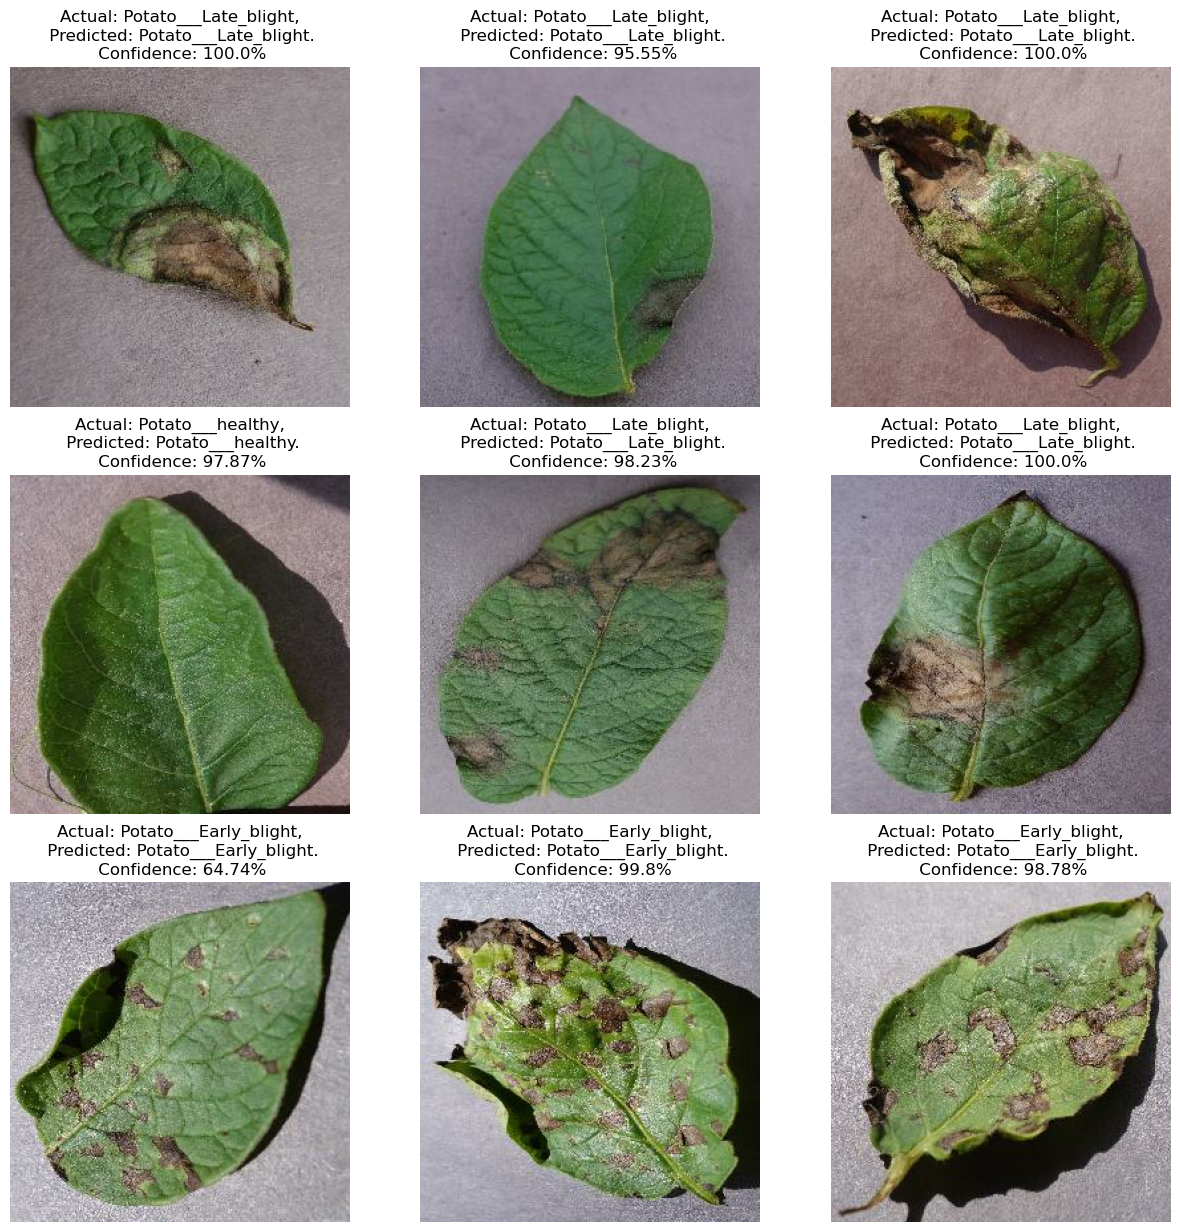

In [44]:
# Using Inference funtion to predict some images:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [49]:
# Saving the model
# Creating a model version so that Each time, when you save a model, 
# It will save as new file by checking all existing files in that directory
import os
model_version=max([int(i) for i in os.listdir("Potato_models") + [0]])+1
model.save(f"Potato_models/{model_version}")

INFO:tensorflow:Assets written to: Potato_models/1\assets


INFO:tensorflow:Assets written to: Potato_models/1\assets
